https://pankajkarman.github.io/bias_correction/index.html

did not found how to do with BiasCorrection, because not indicated what is the type that we should put inside

In [1]:
# import modules and functions

import pandas as pd
import numpy as np

from bias_correction import BiasCorrection
from bias_correction import XBiasCorrection
import xarray as xr
import matplotlib.pyplot as plt

# import data
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import import_treat_obs_NOAA
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA
from Bias_correction_function import treat_data_for_test

In [2]:
# information needed 
climate_var = 'pr' # 'tas'

# precipitation : 'pr'

name_station = 'BEIRA, MZ'
name_project = 'WTP_Mutua_EIB'
name_model = 'ACCESS-CM2'

In [3]:
# import observation data
data_obs_NOAA=import_treat_obs_NOAA()

In [4]:
# value to be corrected
climate_var_NEX_GDDP_CMIP6_Project=import_treat_modeled_NEX_GDDP_CMIP6(climate_var,'mm_per_day','day',1950,2100)

In [5]:
# modeled value
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA(climate_var, 'mm_per_day')

In [6]:
# observation and modeled value in one dataframe
df_pr = treat_data_for_test(data_obs_NOAA,'PRCP',climate_var_NEX_GDDP_CMIP6_EmplacementStation,'Mean of the daily precipitation rate mm/day','BEIRA, MZ',name_model)

# Test with XBiasCorrection

In [7]:
obs_data = df_pr[[('targets','pcp')]].values.reshape((len(df_pr[[('targets','pcp')]].values),))#np.random.randn(2*365, 34, 65)
model_data = df_pr[[('training','pcp')]].values.reshape((len(df_pr[[('training','pcp')]].values),))#np.random.randn(2*365, 34, 65)
sce_data = climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')][['Mean of the daily precipitation rate mm_per_day']].dropna().values.reshape((len(climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')][['Mean of the daily precipitation rate mm_per_day']].dropna().values),))#np.random.randn(365, 34, 65)

lat = -19.375#range(34)
lon = 34.625#range(65)

obs_data = xr.DataArray(obs_data, dims=['time'], \
                        coords=[pd.to_datetime(df_pr.index)])

model_data = xr.DataArray(model_data, dims=['time'], \
                          coords=[pd.to_datetime(df_pr.index)])

sce_data = xr.DataArray(sce_data, dims=['time'], \
                        coords=[pd.to_datetime(climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')]['Date'].dropna().values,format='%d-%m-%Y')])

# combining dataarrays to form dataset with same timelength otherwise correction will give error
#ds = xr.Dataset({'obs_data':obs_data, 'sce_data':sce_data})
ds = xr.Dataset({'model_data':model_data,'obs_data':obs_data, 'sce_data':sce_data})
ds['sce_data']

<xarray.DataArray 'sce_data' (time: 26782)>
array([        nan,         nan,         nan, ...,  0.04030402,
        0.65391477, 23.99671152])
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-01-02 ... 2084-12-31

In [8]:
bc = XBiasCorrection(ds['obs_data'], ds['model_data'], ds['sce_data'])
df1 = bc.correct(method='modified_quantile')
df2 = bc.correct(method='basic_quantile')
df3 = bc.correct(method='gamma_mapping')
df3 = bc.correct(method='normal_mapping')

ValueError: array must not contain infs or NaNs

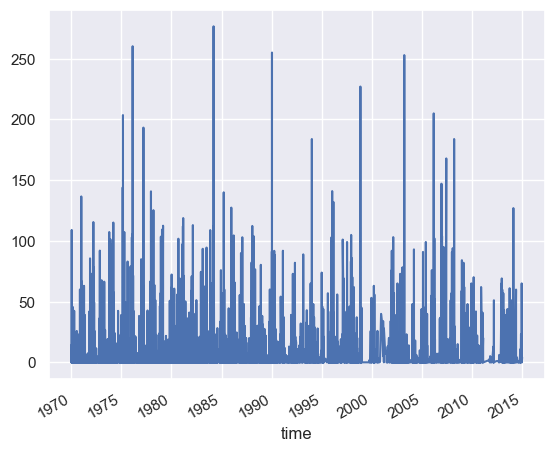

In [9]:
obs_data.plot()

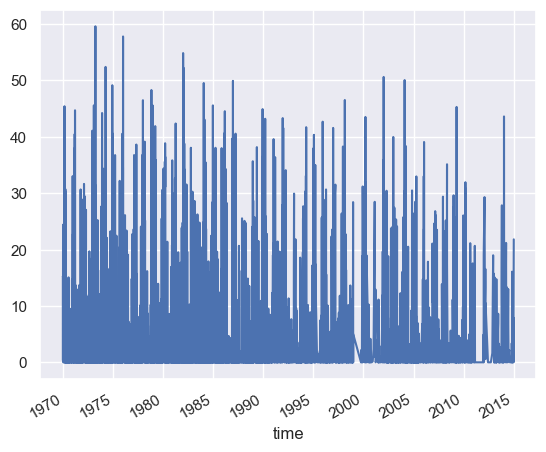

In [10]:
model_data.plot()

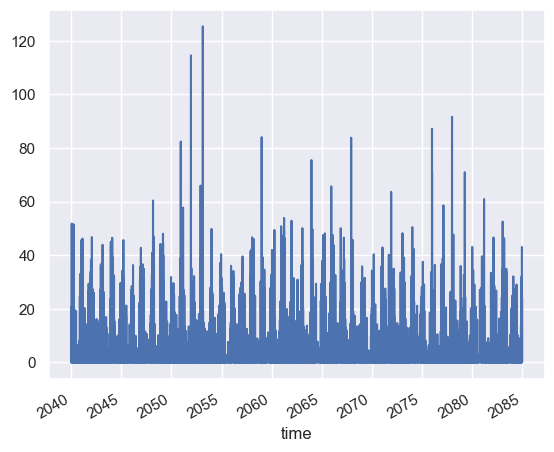

In [11]:
sce_data.plot()

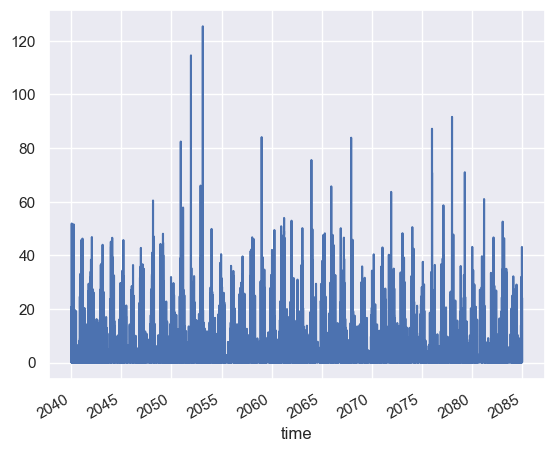

In [31]:
df1.plot()

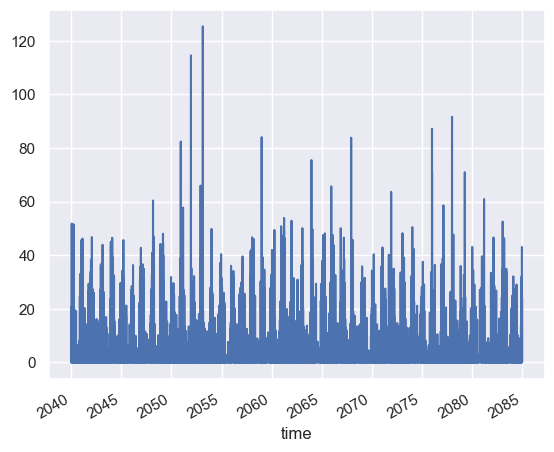

In [28]:
df2.plot()

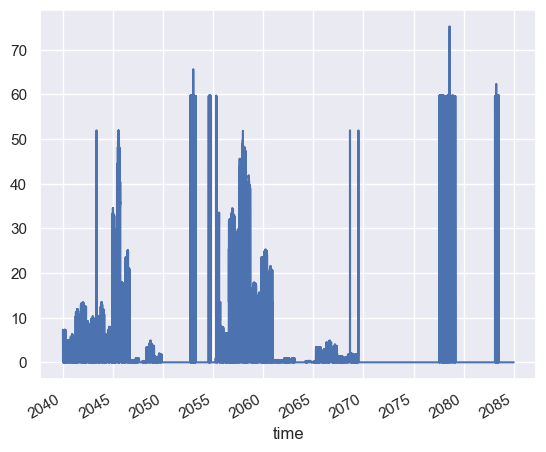

In [24]:
df3[10345:26782].plot()

In [33]:
sum(abs(sce_data.values-df2[10345:26782].values))

0.0

In [23]:
df2[10345:26782]

<xarray.DataArray (time: 16437)>
array([ 0.        ,  0.        ,  9.0212144 , ...,  0.04030402,
        0.65391477, 23.99671152])
Coordinates:
  * time     (time) datetime64[ns] 2040-01-01 2040-01-02 ... 2084-12-31

In [22]:
sce_data

<xarray.DataArray (time: 16437)>
array([ 0.        ,  0.        ,  9.0212144 , ...,  0.04030402,
        0.65391477, 23.99671152])
Coordinates:
  * time     (time) datetime64[ns] 2040-01-01 2040-01-02 ... 2084-12-31

# Test with BiasCorrection

In [54]:
obs_data.shape

(10345, 1)

In [74]:
model_data

,pcp
time,
1970-01-01,15.221261
1970-01-02,15.258603
1970-01-03,3.232764
1970-01-04,0.340715
1970-01-05,2.544045
...,...
2014-12-16,0.000000
2014-12-17,0.095924
2014-12-18,0.272668


In [75]:
sce_data

,Mean of the daily precipitation rate mm_per_day
Date,
2040-01-01,0.000000
2040-01-02,0.000000
2040-01-03,9.021214
2040-01-04,12.337143
2040-01-05,1.218005
...,...
2068-04-23,0.000000
2068-04-24,0.000000
2068-04-25,0.000000


In [73]:
sce_data.index=pd.to_datetime(sce_data.index,format='%d-%m-%Y').strftime('%Y-%m-%d')

In [94]:
data_to_correct = climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')][['Date','Mean of the daily precipitation rate mm_per_day']].set_index('Date').dropna()

In [97]:
data_to_correct=data_to_correct[0:len(model_data)]

In [98]:
data_to_correct.index=pd.to_datetime(data_to_correct.index,format='%d-%m-%Y').strftime('%Y-%m-%d')

In [100]:
time_data_to_correct=data_to_correct.index

Index(['2040-01-01', '2040-01-02', '2040-01-03', '2040-01-04', '2040-01-05',
       '2040-01-06', '2040-01-07', '2040-01-08', '2040-01-09', '2040-01-10',
       ...
       '2068-04-18', '2068-04-19', '2068-04-20', '2068-04-21', '2068-04-22',
       '2068-04-23', '2068-04-24', '2068-04-25', '2068-04-26', '2068-04-27'],
      dtype='object', name='Date', length=10345)

In [156]:
obs_data = df_pr[[('targets','pcp')]].dropna().values.reshape((len(df_pr[[('targets','pcp')]].dropna().values),))#np.random.randn(2*365, 34, 65)
#obs_data.columns = obs_data.columns.droplevel()
model_data = df_pr[[('training','pcp')]].dropna().values.reshape((len(df_pr[[('training','pcp')]].dropna().values),))#np.random.randn(2*365, 34, 65)
#model_data.columns = model_data.columns.droplevel()
#sce_data.index=pd.to_datetime(sce_data.index,format='%d-%m-%Y').strftime('%Y-%m-%d')
data_to_correct = climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')][['Date','Mean of the daily precipitation rate mm_per_day']].set_index('Date').dropna()
data_to_correct=data_to_correct[0:len(model_data)]
time_data_to_correct=data_to_correct.index
data_to_correct=data_to_correct.values.reshape((len(data_to_correct.values),))
#sce_data = climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')][['Date','Mean of the daily precipitation rate mm_per_day']].set_index('Date').dropna().values.reshape((len(climate_var_NEX_GDDP_CMIP6_Project[(climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB') & (climate_var_NEX_GDDP_CMIP6_Project['Year'].between(2040,2084)) & (climate_var_NEX_GDDP_CMIP6_Project['Model']=='ACCESS-CM2') & (climate_var_NEX_GDDP_CMIP6_Project['Experiment']=='ssp370')][['Mean of the daily precipitation rate mm_per_day']].dropna().values),))#np.random.randn(365, 34, 65)
#sce_data = sce_data[0:len(model_data)]
#sce_data.index=pd.to_datetime(sce_data.index,format='%d-%m-%Y').strftime('%Y-%m-%d')

lat = -19.375#range(34)
lon = 34.625#range(65)

obs_data = xr.DataArray(obs_data, dims=['time'], \
                        coords=[pd.to_datetime(df_pr.dropna().index)])

model_data = xr.DataArray(model_data, dims=['time'], \
                          coords=[pd.to_datetime(df_pr.dropna().index)])

sce_data = xr.DataArray(sce_data, dims=['time'], \
                        coords=[pd.to_datetime(df_pr.dropna().index)])#time_data_to_correct])
# combining dataarrays to form dataset with same timelength otherwise correction will give error
#ds = xr.Dataset({'obs_data':obs_data, 'sce_data':sce_data})
ds = xr.Dataset({'model_data':model_data,'obs_data':obs_data, 'sce_data':sce_data})


bc = BiasCorrection(ds['obs_data'].values, ds['model_data'].values, ds['sce_data'].values)
#bc = BiasCorrection(obs_data[['pcp']].values.reshape((len(obs_data[['pcp']]),)), model_data[['pcp']].values.reshape((len(model_data[['pcp']]),)), sce_data)
#df1 = bc.correct(method='modified_quantile')
#df2 = bc.correct(method='basic_quantile')
#df3 = bc.correct(method='gamma_mapping')
df3 = bc.correct(method='normal_mapping')
# type d'error
# avec values : ValueError: Length of values (10345) does not match length of index (1)
# avec que des dataframe : ValueError: object too deep for desired array --> because one element is 2D, and should be 1D


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [115]:
obs_mean, mod_mean, sce_mean = [x.mean() for x in [ds['obs_data'], ds['model_data'], ds['sce_data']]]

In [167]:
df_obs_data= pd.DataFrame()
df_obs_data['obs_data']=ds['obs_data'].values

In [168]:
df_model_data= pd.DataFrame()
df_model_data['model_data']=ds['model_data'].values

In [169]:
df_sce_data= pd.DataFrame()
df_sce_data['sce_data']=ds['sce_data'].values

In [158]:
ds['obs_data'].time

<xarray.DataArray 'time' (time: 10345)>
array(['1970-01-01T00:00:00.000000000', '1970-01-02T00:00:00.000000000',
       '1970-01-03T00:00:00.000000000', ..., '2014-12-18T00:00:00.000000000',
       '2014-12-19T00:00:00.000000000', '2014-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-01-02 ... 2014-12-31

In [170]:
df_sce_data

,sce_data
0,0.000000
1,0.000000
2,9.021214
3,12.337143
4,1.218005
...,...
10340,0.000000
10341,0.000000
10342,0.000000
10343,0.000000


In [171]:
bc = BiasCorrection(df_obs_data, df_model_data, df_sce_data)
#bc = BiasCorrection(obs_data[['pcp']].values.reshape((len(obs_data[['pcp']]),)), model_data[['pcp']].values.reshape((len(model_data[['pcp']]),)), sce_data)
#df1 = bc.correct(method='modified_quantile')
#df2 = bc.correct(method='basic_quantile')
#df3 = bc.correct(method='gamma_mapping')
df3 = bc.correct(method='normal_mapping')

ValueError: object too deep for desired array

In [172]:
obs_data = ds['obs_data'].values
mod_data = ds['model_data'].values
sce_data = ds['sce_data'].values

In [173]:
from scipy.stats import gamma, norm
cdf_threshold=0.9999999

In [174]:
    obs_len, mod_len, sce_len = [len(x) for x in [obs_data, mod_data, sce_data]]
    obs_mean, mod_mean, sce_mean = [x.mean() for x in [obs_data, mod_data, sce_data]]
    obs_detrended, mod_detrended, sce_detrended = [
        detrend(x) for x in [obs_data, mod_data, sce_data]
    ]
    obs_norm, mod_norm, sce_norm = [
        norm.fit(x) for x in [obs_detrended, mod_detrended, sce_detrended]
    ]

    obs_cdf = norm.cdf(np.sort(obs_detrended), *obs_norm)
    mod_cdf = norm.cdf(np.sort(mod_detrended), *mod_norm)
    sce_cdf = norm.cdf(np.sort(sce_detrended), *sce_norm)

    obs_cdf = np.maximum(np.minimum(obs_cdf, cdf_threshold), 1 - cdf_threshold)
    mod_cdf = np.maximum(np.minimum(mod_cdf, cdf_threshold), 1 - cdf_threshold)
    sce_cdf = np.maximum(np.minimum(sce_cdf, cdf_threshold), 1 - cdf_threshold)

    sce_diff = sce_data - sce_detrended
    sce_argsort = np.argsort(sce_detrended)

    obs_cdf_intpol = np.interp(
        np.linspace(1, obs_len, sce_len), np.linspace(1, obs_len, obs_len), obs_cdf
    )
    mod_cdf_intpol = np.interp(
        np.linspace(1, mod_len, sce_len), np.linspace(1, mod_len, mod_len), mod_cdf
    )
    obs_cdf_shift, mod_cdf_shift, sce_cdf_shift = [
        (x - 0.5) for x in [obs_cdf_intpol, mod_cdf_intpol, sce_cdf]
    ]

    obs_inverse, mod_inverse, sce_inverse = [
        1.0 / (0.5 - np.abs(x)) for x in [obs_cdf_shift, mod_cdf_shift, sce_cdf_shift]
    ]

    adapted_cdf = np.sign(obs_cdf_shift) * (
        1.0 - 1.0 / (obs_inverse * sce_inverse / mod_inverse)
    )
    adapted_cdf[adapted_cdf < 0] += 1.0
    adapted_cdf = np.maximum(np.minimum(adapted_cdf, cdf_threshold), 1 - cdf_threshold)

In [175]:
xvals = norm.ppf(np.sort(adapted_cdf), *obs_norm) + obs_norm[-1] / mod_norm[-1] * (norm.ppf(sce_cdf, *sce_norm) - norm.ppf(sce_cdf, *mod_norm))

In [176]:
xvals += obs_mean + (sce_mean - mod_mean)

In [177]:
xvals

array([-1.54993968, -1.54983181, -1.54939358, ..., 87.72888571,
       87.72888571, 87.72888571])

In [178]:

correction = np.zeros(sce_len)
correction[sce_argsort] = xvals
correction += sce_diff - sce_mean

In [182]:
max(correction)

87.82335238144641

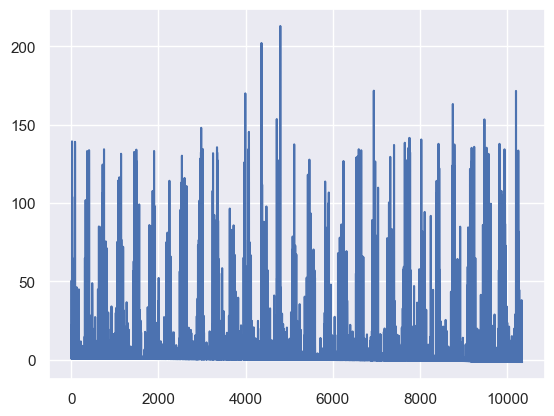

In [184]:
plt.plot(correction+ds['sce_data'].values)

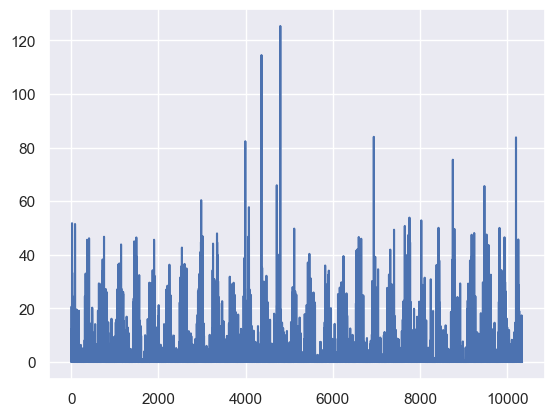

In [185]:
plt.plot(ds['sce_data'].values)

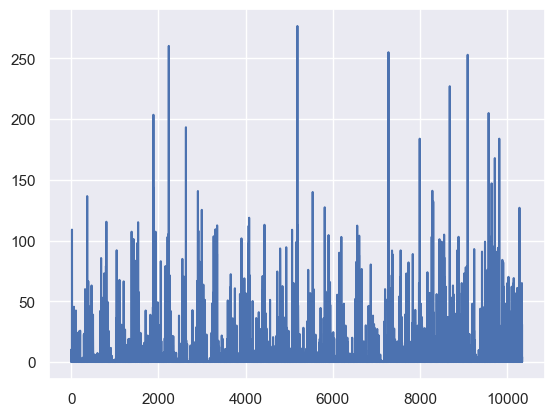

In [186]:
plt.plot(ds['obs_data'].values)

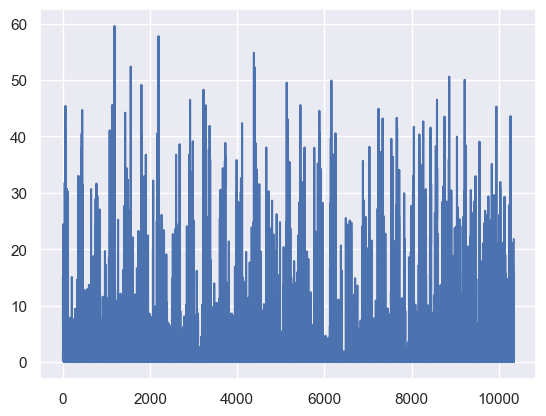

In [187]:
plt.plot(ds['model_data'].values)